### **Importing libraries**

In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.init as init
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader, TensorDataset

In [2]:
torch.manual_seed(42)
np.random.seed(42)

### **Data Preparation**

In [3]:
iris = load_iris()

X = iris.data
y = iris.target

print(X.shape)
print(y.shape)

print("Target names: ", iris.target_names)
print("Feature names: ", iris.feature_names)

(150, 4)
(150,)
Target names:  ['setosa' 'versicolor' 'virginica']
Feature names:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizing features
scalar = MinMaxScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

# Converting to PyTorch sensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([120, 4])
torch.Size([30, 4])
torch.Size([120])
torch.Size([30])


### **Model Adaptation**

In [5]:
class SKAModel(nn.Module):
  def __init__(self, input_size=4, layer_sizes=[32, 16, 3], K=2000):
    super(SKAModel, self).__init__()
    self.input_size = input_size
    self.layer_sizes = layer_sizes
    self.K = K

    self.weights = nn.ParameterList()
    self.biases = nn.ParameterList()
    prev_size = input_size
    for size in layer_sizes:
      self.weights.append(nn.Parameter(torch.randn(prev_size, size) * 0.1))
      self.biases.append(nn.Parameter(torch.zeros(size)))
      prev_size = size

    # Tracking tensors for knowledge accumulation and entropy computation
    self.Z = [None] * len(layer_sizes)
    self.Z_prev = [None] * len(layer_sizes)
    self.D = [None] * len(layer_sizes)
    self.D_prev = [None] * len(layer_sizes)
    self.delta_D = [None] * len(layer_sizes)
    self.entropy = [None] * len(layer_sizes)

    # Storing histories for visualization
    self.entropy_history = [[] for _ in range(len(layer_sizes))]
    self.cosine_history = [[] for _ in range(len(layer_sizes))]
    self.output_history = []
    self.frobenius_history = [[] for _ in range(len(layer_sizes))]
    self.weight_frobenius_history = [[] for _ in range(len(layer_sizes))]
    self.net_history = [[] for _ in range(len(layer_sizes))]
    self.tensor_net_total = [0.0] * len(layer_sizes)

  def forward(self, x):
    for l in range(len(self.layer_sizes)):
      z = torch.mm(x, self.weights[l]) + self.biases[l]

      if l == 0:
        z = z * 5.0 / (torch.norm(z, p='fro') + 1e-5)
        d = torch.sigmoid(z)
      elif l == 1:
        z = z * 5.0 / (torch.norm(z, p='fro') + 1e-5) + torch.randn_like(z) * 0.01  # Add noise
        d = torch.relu(z)
      else:
        z = z * 10.0 / (torch.norm(z, p='fro') + 1e-5)  # Cap output logits
        d = z

      self.Z[l] = z
      self.D[l] = d
      frobenius_norm = torch.norm(z, p='fro')
      self.frobenius_history[l].append(frobenius_norm.item())
      x = d

    return x

  def calculate_entropy(self):
    # Compute entropy reduction using internal previous states
    total_entropy = 0
    for i in range(len(self.layer_sizes)):
      if self.Z[i] is not None and self.Z_prev[i] is not None and self.D[i] is not None and self.D_prev[i] is not None:
        self.delta_D[i] = self.D[i] - self.D_prev[i]
        delta_Z = self.Z[i] - self.Z_prev[i]

        dot_product = torch.sum(self.Z[i] * self.delta_D[i])
        layer_entropy = -1 / np.log(2) * dot_product
        layer_entropy = torch.clamp(layer_entropy, -10, 10)

        print(f"Layer {i}: dot_product={dot_product.item():.4f}, entropy={layer_entropy.item():.4f}, "
              f"Z_norm={torch.norm(self.Z[i]).item():.4f}, D_norm={torch.norm(self.D[i]).item():.4f}, "
              f"delta_D_norm={torch.norm(self.delta_D[i]).item():.4f}")

        self.entropy[i] = layer_entropy.item()
        self.entropy_history[i].append(layer_entropy.item())

        z_norm = torch.norm(self.Z[i])
        delta_d_norm = torch.norm(self.delta_D[i])
        if z_norm > 0 and delta_d_norm > 0:
            cos_theta = dot_product / (z_norm * delta_d_norm)
            self.cosine_history[i].append(cos_theta.item())
        else:
            self.cosine_history[i].append(0.0)

        total_entropy += layer_entropy

        tensor_net_step = torch.sum((self.D[i] - layer_entropy) * delta_Z)
        self.net_history[i].append(tensor_net_step.item())
        self.tensor_net_total[i] = tensor_net_step.item()
      else:
        self.entropy_history[i].append(0.0)
        self.cosine_history[i].append(0.0)
        self.net_history[i].append(0.0)

    return total_entropy

  def ska_update(self, inputs, learning_rate=1.0):
    for i in range(len(self.layer_sizes)):
      if self.delta_D[i] is not None:
        prev_output = inputs if i == 0 else self.D[i-1]
        d_prime = self.D[i] * (1 - self.D[i]) if i == 0 else (self.D[i] > 0).float() if i == 1 else torch.ones_like(self.D[i])
        gradient = -1 / np.log(2) * (self.Z[i] * d_prime + self.delta_D[i])
        gradient_norm = torch.norm(gradient)

        if gradient_norm > 0:
          gradient = gradient / gradient_norm
        gradient = torch.clamp(gradient, -1, 1)

        if i == 1:
          noise = torch.randn_like(gradient) * 0.01
          gradient += noise

        lr = learning_rate if i != 2 else 0.5
        dW = torch.matmul(prev_output.t(), gradient) / prev_output.shape[0]
        self.weights[i] = self.weights[i] - lr * dW
        self.biases[i] = self.biases[i] - lr * gradient.mean(dim=0)

  def initialize_tensors(self, batch_size):
    # Initialize tensors with the full training size, reset histories
    for i in range(len(self.layer_sizes)):
      self.Z[i] = torch.zeros(batch_size, self.layer_sizes[i])
      self.Z_prev[i] = torch.zeros(batch_size, self.layer_sizes[i])
      self.D[i] = torch.zeros(batch_size, self.layer_sizes[i])
      self.D_prev[i] = torch.zeros(batch_size, self.layer_sizes[i])
      self.delta_D[i] = None
      self.entropy[i] = None
      self.entropy_history[i] = []
      self.cosine_history[i] = []
      self.frobenius_history[i] = []
      self.weight_frobenius_history[i] = []
      self.net_history[i] = []
      self.tensor_net_total[i] = 0.0

    self.output_history = []

  def visualize_entropy_heatmap(self, step):
    # Dynamically scales the heatmap range and visualizes entropy reduction.
    entropy_data = np.array(self.entropy_history)
    vmin = np.min(entropy_data)
    vmax = 0.0

    plt.figure(figsize=(12, 8))

    sns.heatmap(entropy_data, cmap="Blues_r", vmin=vmin, vmax=vmax,
                xticklabels=range(1, entropy_data.shape[1] + 1),
                yticklabels=[f"Layer {i+1}" for i in range(len(self.layer_sizes))])

    plt.title(f"Layer-wise Entropy Heatmap (Step {step})")
    plt.xlabel("Step Index K")
    plt.ylabel("Network Layers")
    plt.tight_layout()
    plt.savefig(f"entropy_heatmap_step_{step}.png")
    plt.show()

  def visualize_cosine_heatmap(self, step):
    # Visualizes cos(theta) alignment heatmap with a diverging scale.
    cosine_data = np.array(self.cosine_history)

    plt.figure(figsize=(12, 8))

    sns.heatmap(cosine_data, cmap="coolwarm_r", vmin=-1.0, vmax=1.0,
                xticklabels=range(1, cosine_data.shape[1] + 1),
                yticklabels=[f"Layer {i+1}" for i in range(len(self.layer_sizes))])

    plt.title(f"Layer-wise Cos(\u03B8) Alignment Heatmap (Step {step})")
    plt.xlabel("Step Index K")
    plt.ylabel("Network Layers")
    plt.tight_layout()
    plt.savefig(f"cosine_heatmap_step_{step}.png")
    plt.show()

  def visualize_frobenius_heatmap(self, step):
    # Visualizes the Frobenius Norm heatmap for the knowledge tensor Z across layers.
    frobenius_data = np.array(self.frobenius_history)
    vmin = np.min(frobenius_data) if frobenius_data.size > 0 else 0
    vmax = np.max(frobenius_data) if frobenius_data.size > 0 else 1

    plt.figure(figsize=(12, 8))

    sns.heatmap(frobenius_data, cmap="viridis", vmin=vmin, vmax=vmax,
                xticklabels=range(1, frobenius_data.shape[1] + 1),
                yticklabels=[f"Layer {i+1}" for i in range(len(self.layer_sizes))])

    plt.title(f"Layer-wise Frobenius Norm Heatmap (Step {step})")
    plt.xlabel("Step Index K")
    plt.ylabel("Network Layers")
    plt.tight_layout()
    plt.savefig(f"knowledge_frobenius_heatmap_step_{step}.png")
    plt.show()

  def visualize_weight_frobenius_heatmap(self, step):
    # Visualizes the Frobenius Norm heatmap for the weight tensors W across layers.
    weight_data = np.array(self.weight_frobenius_history)
    vmin = np.min(weight_data) if weight_data.size > 0 else 0
    vmax = np.max(weight_data) if weight_data.size > 0 else 1

    plt.figure(figsize=(12, 8))

    sns.heatmap(weight_data, cmap="plasma", vmin=vmin, vmax=vmax,
                xticklabels=range(1, weight_data.shape[1] + 1),
                yticklabels=[f"Layer {i+1}" for i in range(len(self.layer_sizes))])

    plt.title(f"Layer-wise Weight Frobenius Norm Heatmap (Step {step})")
    plt.xlabel("Step Index K")
    plt.ylabel("Network Layers")
    plt.tight_layout()
    plt.savefig(f"weight_frobenius_heatmap_step_{step}.png")
    plt.show()

  def visualize_output_distribution(self):
    # Plots the evolution of the 10-class output distribution over K steps.
    output_data = np.array(self.output_history)

    plt.figure(figsize=(10, 6))

    plt.plot(output_data)
    plt.title('Output Decision Probability Evolution Across Steps (Single Pass)')
    plt.xlabel('Step Index K')
    plt.ylabel('Mean Sigmoid Output')
    plt.legend([f"Class {i}" for i in range(10)], loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("output_distribution_single_pass.png")
    plt.show()

  def visualize_net_heatmap(self, step):
    # Visualizes the per-step Tensor Net heatmap.
    net_data = np.array(self.net_history)
    vmin = np.min(net_data) if net_data.size > 0 else 0
    vmax = np.max(net_data) if net_data.size > 0 else 1

    plt.figure(figsize=(12, 8))

    sns.heatmap(net_data, cmap="magma", vmin=vmin, vmax=vmax,
                xticklabels=range(1, net_data.shape[1] + 1),
                yticklabels=[f"Layer {i+1}" for i in range(len(self.layer_sizes))])

    plt.title(f"Tensor Net Heatmap (Step {step})")
    plt.xlabel("Step Index K")
    plt.ylabel("Network Layers")
    plt.tight_layout()
    plt.savefig(f"tensor_net_heatmap_step_{step}.png")
    plt.show()

  def visualize_net_history(self):
    # Plots the historical evolution of Tensor Net across layers.
    net_data = np.array(self.net_history).T

    plt.figure(figsize=(8, 6))

    plt.plot(net_data)
    plt.title('Tensor Net Evolution Across Layers (Single Pass)')
    plt.xlabel('Step Index K')
    plt.ylabel('Tensor Net Value')
    plt.legend([f"Layer {i+1}" for i in range(len(self.layer_sizes))])
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("tensor_net_history_single_pass.png")
    plt.show()

  def visualize_entropy_vs_frobenius(self, step):
    # Plots entropy reduction against Frobenius norm of Z for each layer.
    plt.figure(figsize=(12, 10))

    for l in range(len(self.layer_sizes)):
      plt.subplot(2, 2, l + 1)

      # Skip if we don't have enough data points
      if len(self.entropy_history[l]) < 2 or len(self.frobenius_history[l]) < 2:
        plt.title(f"Layer {l+1}: Not enough data")
        continue

      # Get entropy and frobenius data for this layer
      entropy_data = self.entropy_history[l]
      frobenius_data = self.frobenius_history[l][1:]  # Match entropy step indices

      # Ensure same length
      min_len = min(len(entropy_data), len(frobenius_data))
      entropy_data = entropy_data[:min_len]
      frobenius_data = frobenius_data[:min_len]

      # Create scatter plot with connected lines
      plt.scatter(frobenius_data, entropy_data, c=range(len(entropy_data)),
                  cmap='Blues_r', s=50, alpha=0.8)
      plt.plot(frobenius_data, entropy_data, 'k-', alpha=0.3)

      # Add colorbar to show step progression
      cbar = plt.colorbar()
      cbar.set_label('Step')

      # Add labels and title
      plt.xlabel('Frobenius Norm of Knowledge Tensor Z')
      plt.ylabel('Entropy Reduction')
      plt.title(f'Layer {l+1}: Entropy vs. Knowledge Magnitude')
      plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"entropy_vs_frobenius_step_{step}.png")
    plt.show()

  def plot_entropy_reduction(self):
    plt.figure(figsize=(10, 6))
    for l in range(len(self.layer_sizes)):
      plt.plot(self.entropy_history[l], label=f"Layer {l}")
    plt.title("Entropy Reduction per Layer")
    plt.xlabel("Step")
    plt.ylabel("Entropy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("entropy_reduction.png")
    plt.show()

  def plot_knowledge_tensor_magnitudes(self):
    plt.figure(figsize=(10, 6))
    for l in range(len(self.layer_sizes)):
      plt.plot(self.frobenius_history[l], label=f"Layer {l}")
    plt.title("Knowledge Tensor (Z) Magnitudes")
    plt.xlabel("Step")
    plt.ylabel("Frobenius Norm")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("knowledge_tensor_magnitudes.png")
    plt.show()

  def plot_decision_probability_evolution(self):
    plt.figure(figsize=(10, 6))
    outputs = np.array(self.output_history)
    softmax_outputs = np.exp(outputs) / np.sum(np.exp(outputs), axis=1, keepdims=True)
    for i in range(3):
      plt.plot(softmax_outputs[:, i], label=f"Class {i}")
    plt.title("Decision Probability Evolution")
    plt.xlabel("Step")
    plt.ylabel("Softmax Probability")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("decision_probability_evolution.png")
    plt.show()

  def plot_weight_changes(self):
    plt.figure(figsize=(10, 6))
    for l in range(len(self.layer_sizes)):
      plt.plot(self.weight_frobenius_history[l], label=f"Layer {l}")
    plt.title("Weight Changes During Training")
    plt.xlabel("Step (every 50)")
    plt.ylabel("Frobenius Norm")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("weight_changes.png")
    plt.show()

### **Training and Evaluation**

Streaming output truncated to the last 5000 lines.
Layer 1: dot_product=0.0346, entropy=-0.0499, Z_norm=4.9980, D_norm=4.9977, delta_D_norm=0.2948
Layer 2: dot_product=0.0031, entropy=-0.0045, Z_norm=10.0000, D_norm=10.0000, delta_D_norm=0.0790
Layer 0: dot_product=0.1832, entropy=-0.2643, Z_norm=5.0000, D_norm=16.2832, delta_D_norm=0.3013
Layer 1: dot_product=0.0517, entropy=-0.0745, Z_norm=4.9987, D_norm=4.9984, delta_D_norm=0.3033
Layer 2: dot_product=0.0028, entropy=-0.0040, Z_norm=10.0000, D_norm=10.0000, delta_D_norm=0.0742
Layer 0: dot_product=0.3897, entropy=-0.5623, Z_norm=5.0000, D_norm=16.2839, delta_D_norm=0.4386
Layer 1: dot_product=0.0191, entropy=-0.0276, Z_norm=4.9935, D_norm=4.9933, delta_D_norm=0.2917
Layer 2: dot_product=0.0021, entropy=-0.0031, Z_norm=10.0000, D_norm=10.0000, delta_D_norm=0.0650
Step: 1500, Pseudo-Loss: 0.4778, Entropy: -0.4778
Layer 0: dot_product=0.3384, entropy=-0.4883, Z_norm=5.0000, D_norm=16.2839, delta_D_norm=0.4085
Layer 1: dot_product=0.070

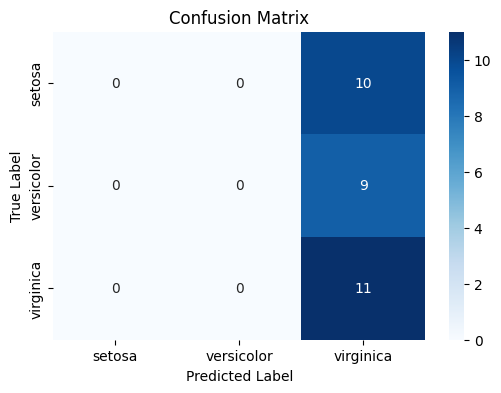

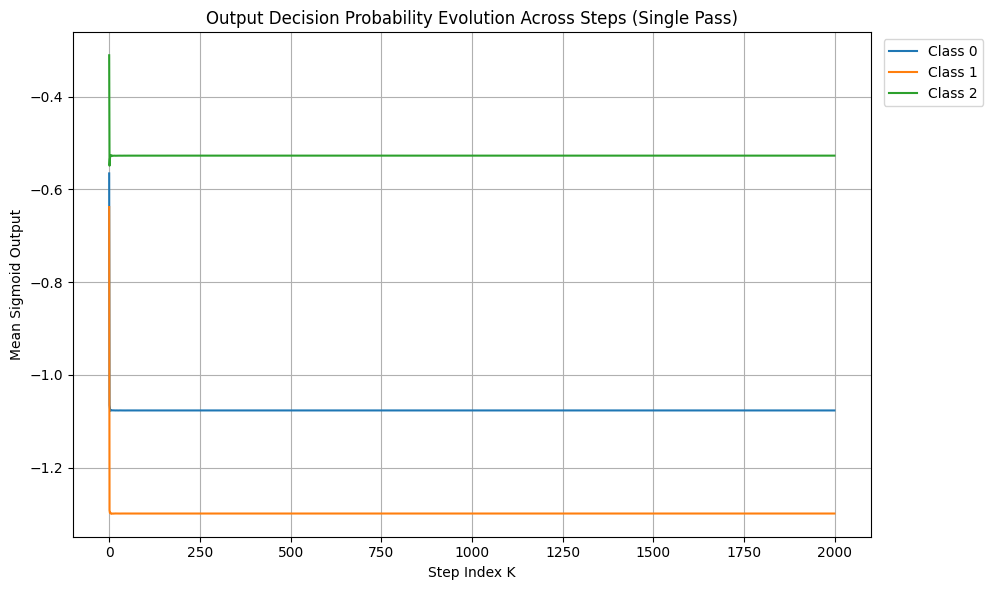

In [6]:
model = SKAModel(input_size=4, layer_sizes=[32, 16, 3], K=2000)
learning_rate_ska = 0.5
criterion = nn.CrossEntropyLoss()
learning_rate_supervised = 0.02
optimizer = optim.Adam(model.parameters(), lr=learning_rate_supervised)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
model.initialize_tensors(X_train.size(0))

losses = []
start_time = time.time()
net_threshold = 1e-4

for k in range(model.K):
    model.train()
    if k == 0:
        outputs = model(X_train)
        model.output_history.append(outputs.mean(dim=0).detach().cpu().numpy())
        model.D_prev = [d.clone().detach() if d is not None else None for d in model.D]
        model.Z_prev = [z.clone().detach() if z is not None else None for z in model.Z]
        continue

    # Mini-batch training with SKA updates
    epoch_entropy = 0.0
    batch_outputs = []
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        if k > 1:  # Skip entropy calc on first update (no delta yet)
            batch_entropy = model.calculate_entropy()
            model.ska_update(X_batch, learning_rate_ska)
            epoch_entropy += batch_entropy.item()

        if k % 5 == 0:
          loss = criterion(outputs, y_batch)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        batch_outputs.append(outputs.mean(dim=0).detach().cpu().numpy())

        # Update internal previous states after each batch
        model.D_prev = [d.clone().detach() if d is not None else None for d in model.D]
        model.Z_prev = [z.clone().detach() if z is not None else None for z in model.Z]

    # Average outputs across batches for history
    model.output_history.append(np.mean(batch_outputs, axis=0))

    # Update histories and visualizations
    if k > 1:
        avg_entropy = epoch_entropy / len(train_loader)
        pseudo_loss = -avg_entropy
        losses.append(pseudo_loss)
        print(f"Step: {k}, Pseudo-Loss: {pseudo_loss:.4f}, Entropy: {avg_entropy:.4f}")

        if k % 50 == 0:
          for l in range(len(model.layer_sizes)):
              weight_norm = torch.norm(model.weights[l], p='fro')
              model.weight_frobenius_history[l].append(weight_norm.item())

          # model.visualize_entropy_heatmap(k)
          # model.visualize_cosine_heatmap(k)
          # model.visualize_frobenius_heatmap(k)
          # model.visualize_weight_frobenius_heatmap(k)
          # model.visualize_net_heatmap(k)
          # model.visualize_entropy_vs_frobenius(k)

          # Check Tensor Net for early stopping
          if all(abs(model.tensor_net_total[l]) < net_threshold for l in range(len(model.layer_sizes))):
            print(f"Early stopping at step {k}: Tensor Net converged")
            break

total_time = time.time() - start_time

model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test)
    y_pred = torch.argmax(y_pred_logits, dim=1)
    final_acc = (y_pred == y_test).float().mean().item()
    print(f"Training Complete: Time = {total_time:.2f}s, Final Accuracy: {final_acc * 100:.2f}%")

    cm = confusion_matrix(y_test.numpy(), y_pred.numpy())
    plt.figure(figsize = (6, 4))
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = iris.target_names, yticklabels = iris.target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title("Confusion Matrix")
    plt.show()

model.visualize_output_distribution()

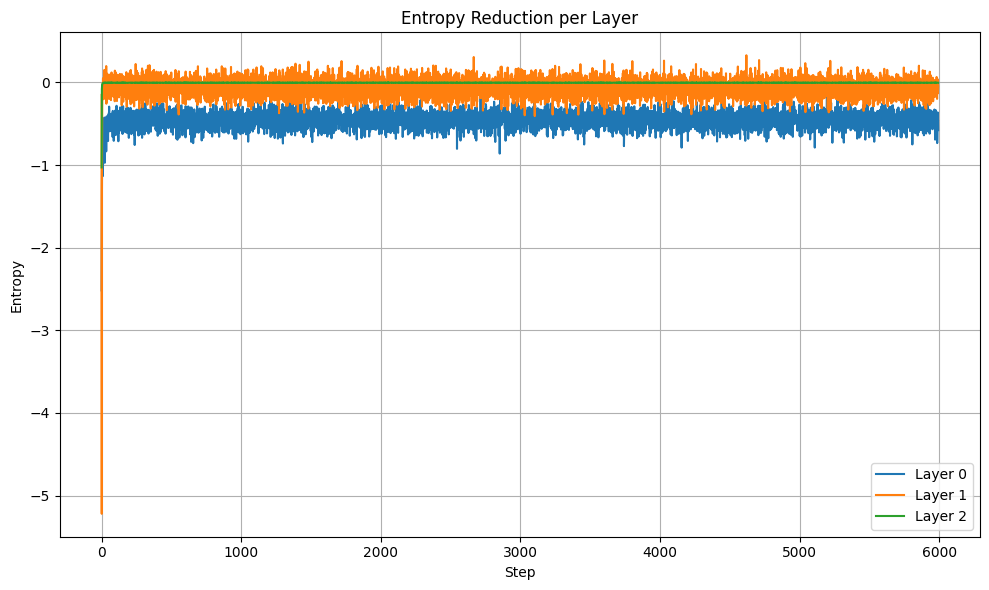

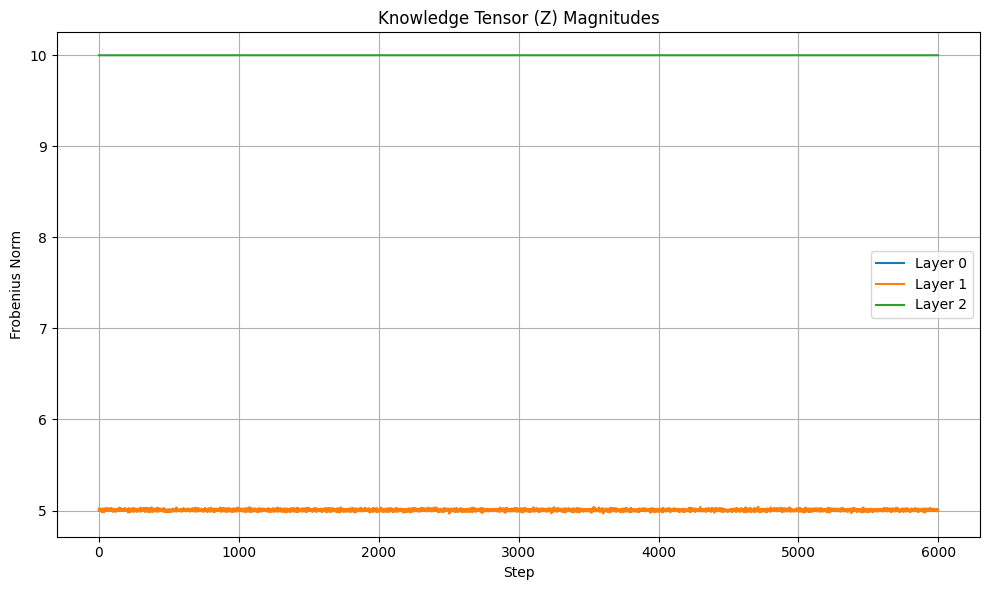

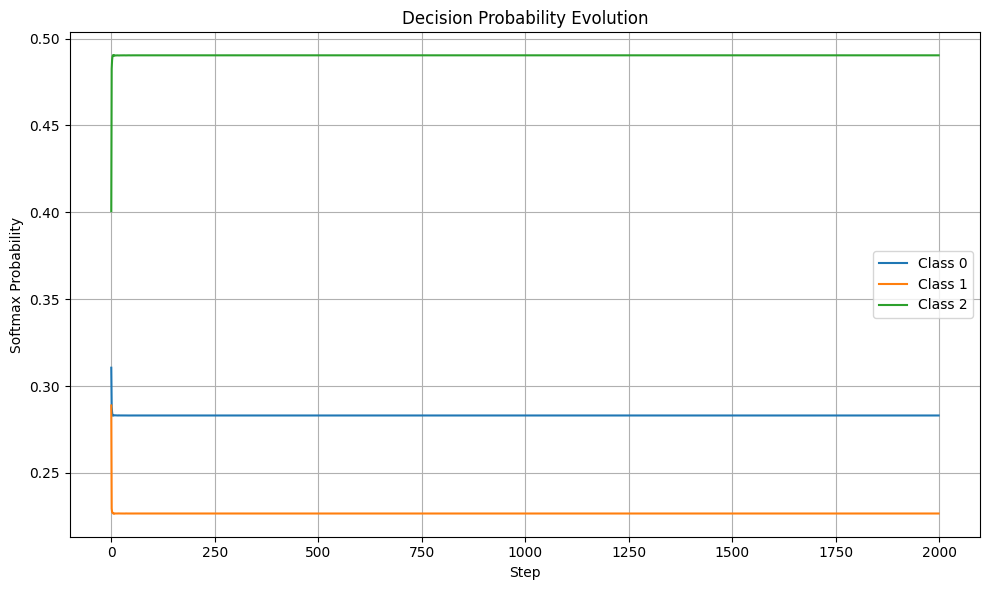

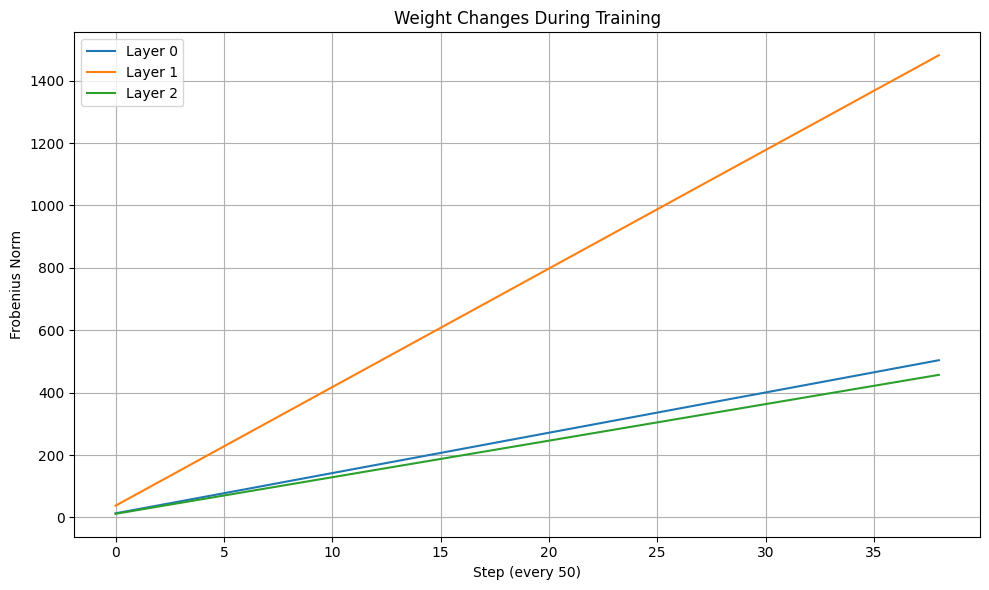

In [7]:
model.plot_entropy_reduction()
model.plot_knowledge_tensor_magnitudes()
model.plot_decision_probability_evolution()
model.plot_weight_changes()

In [8]:
model = SKAModel(layer_sizes=[32, 16, 3], K=1000)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000, eta_min=0.00001)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
model.initialize_tensors(X_train.size(0))

losses = []
best_acc = 0.0
best_model_state = None
patience = 50
counter = 0
start_time = time.time()

for k in range(model.K):
    model.train()
    if k == 0:
        outputs = model(X_train)
        model.D_prev = [d.clone().detach() if d is not None else None for d in model.D]
        model.Z_prev = [z.clone().detach() if z is not None else None for z in model.Z]
        continue
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    scheduler.step()
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Step: {k}, Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    if k % 10 == 0:
        model.eval()
        with torch.no_grad():
            y_pred_logits = model(X_test)
            y_pred = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
            acc = (y_pred == y_test).float().mean().item()
            print(f"Step {k} Test Accuracy: {acc * 100:.2f}%")
            if acc > best_acc:
                best_acc = acc
                best_model_state = model.state_dict()
                counter = 0
            else:
                counter += 1
            if counter >= patience:
                print(f"Early stopping at step {k}")
                break
        model.train()

total_time = time.time() - start_time
model.load_state_dict(best_model_state)
print(f"Training Complete: Time = {total_time:.2f}s, Best Accuracy: {best_acc * 100:.2f}%")

Step: 1, Loss: 1.2319, LR: 0.010000
Step: 2, Loss: 1.0929, LR: 0.010000
Step: 3, Loss: 1.0838, LR: 0.010000
Step: 4, Loss: 1.0820, LR: 0.010000
Step: 5, Loss: 1.0762, LR: 0.009999
Step: 6, Loss: 1.0673, LR: 0.009999
Step: 7, Loss: 1.0658, LR: 0.009999
Step: 8, Loss: 1.0282, LR: 0.009998
Step: 9, Loss: 1.0072, LR: 0.009998
Step: 10, Loss: 0.9761, LR: 0.009998
Step 10 Test Accuracy: 70.00%
Step: 11, Loss: 0.8605, LR: 0.009997
Step: 12, Loss: 0.7134, LR: 0.009996
Step: 13, Loss: 0.6540, LR: 0.009996
Step: 14, Loss: 0.5920, LR: 0.009995
Step: 15, Loss: 0.5844, LR: 0.009994
Step: 16, Loss: 0.5721, LR: 0.009994
Step: 17, Loss: 0.5333, LR: 0.009993
Step: 18, Loss: 0.5447, LR: 0.009992
Step: 19, Loss: 0.5431, LR: 0.009991
Step: 20, Loss: 0.5301, LR: 0.009990
Step 20 Test Accuracy: 96.67%
Step: 21, Loss: 0.5040, LR: 0.009989
Step: 22, Loss: 0.5108, LR: 0.009988
Step: 23, Loss: 0.5114, LR: 0.009987
Step: 24, Loss: 0.4976, LR: 0.009986
Step: 25, Loss: 0.5127, LR: 0.009985
Step: 26, Loss: 0.4927, 

Final Accuracy: 93.33%


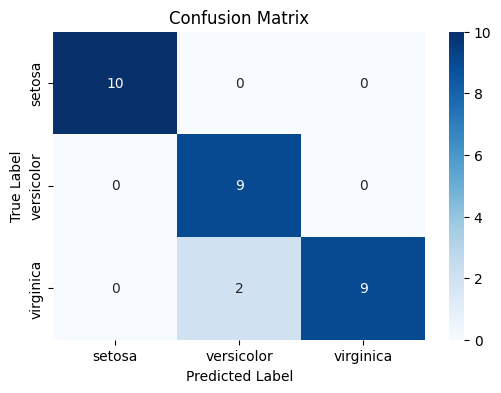

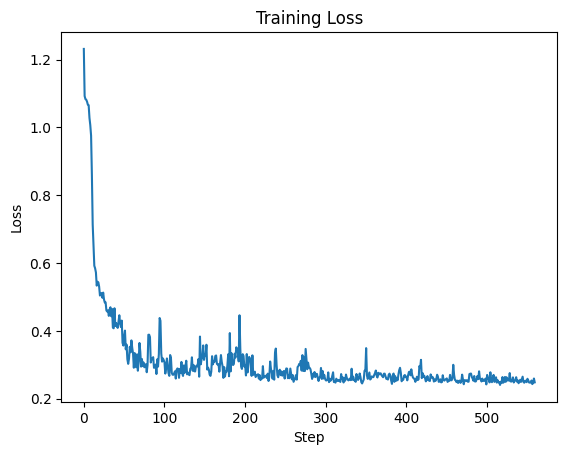

In [9]:
# Final evaluation
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test)
    y_pred = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
    accuracy = (y_pred == y_test).float().mean().item()
    print(f"Final Accuracy: {accuracy * 100:.2f}%")

    cm = confusion_matrix(y_test.numpy(), y_pred.numpy())

    plt.figure(figsize = (6, 4))
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = iris.target_names, yticklabels = iris.target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title("Confusion Matrix")
    plt.show()

# Plot loss
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

### **Analysis and Comparison**

Epoch 0, Loss: 1.1136, Test Accuracy: 36.67%
Epoch 10, Loss: 1.0103, Test Accuracy: 93.33%
Epoch 20, Loss: 0.8532, Test Accuracy: 86.67%
Epoch 30, Loss: 0.6581, Test Accuracy: 90.00%
Epoch 40, Loss: 0.5000, Test Accuracy: 93.33%
Epoch 50, Loss: 0.3998, Test Accuracy: 93.33%
Epoch 60, Loss: 0.3301, Test Accuracy: 96.67%
Epoch 70, Loss: 0.2758, Test Accuracy: 100.00%
Epoch 80, Loss: 0.2311, Test Accuracy: 100.00%
Epoch 90, Loss: 0.1942, Test Accuracy: 100.00%
Epoch 100, Loss: 0.1642, Test Accuracy: 100.00%
Epoch 110, Loss: 0.1407, Test Accuracy: 100.00%
Epoch 120, Loss: 0.1229, Test Accuracy: 96.67%
Epoch 130, Loss: 0.1095, Test Accuracy: 96.67%
Epoch 140, Loss: 0.0993, Test Accuracy: 96.67%
Epoch 150, Loss: 0.0915, Test Accuracy: 96.67%
Epoch 160, Loss: 0.0854, Test Accuracy: 96.67%
Epoch 170, Loss: 0.0805, Test Accuracy: 96.67%
Epoch 180, Loss: 0.0765, Test Accuracy: 96.67%
Epoch 190, Loss: 0.0732, Test Accuracy: 96.67%
Epoch 200, Loss: 0.0704, Test Accuracy: 96.67%
Epoch 210, Loss: 0.

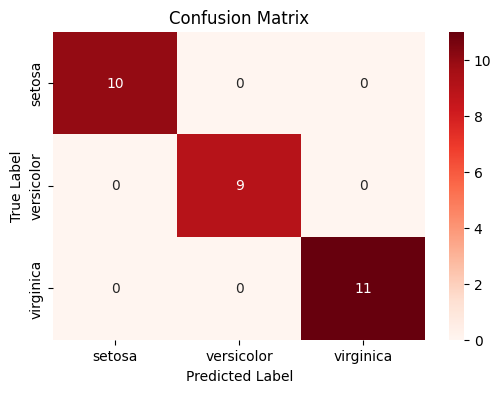

In [10]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )

    def forward(self, x):
        z0 = self.layers[0](x)  # Pre-activation for layer 1
        x = self.layers[1](z0)  # ReLU
        z1 = self.layers[2](x)  # Pre-activation for layer 2 (logits)
        return z1

# Training SimpleNN
model_nn = SimpleNN()
optimizer = optim.Adam(model_nn.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

for epoch in range(500):
    model_nn.train()
    outputs = model_nn(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        model_nn.eval()
        with torch.no_grad():
            y_pred_logits = model_nn(X_test)
            y_pred = torch.argmax(y_pred_logits, dim=1)
            acc = (y_pred == y_test).float().mean().item()
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Test Accuracy: {acc * 100:.2f}%")

# Final evaluation
model_nn.eval()
with torch.no_grad():
    y_pred_logits = model_nn(X_test)
    y_pred = torch.argmax(y_pred_logits, dim=1)
    accuracy = (y_pred == y_test).float().mean().item()
    print(f"NN Final Accuracy: {accuracy * 100:.2f}%")

    cm = confusion_matrix(y_test.numpy(), y_pred.numpy())

    plt.figure(figsize = (6, 4))
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Reds', xticklabels = iris.target_names, yticklabels = iris.target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title("Confusion Matrix")
    plt.show()